 # 实验二： 基于卷积神经网络的 CIFAR-10 数据集分类

## 0. 准备工作

导入所需要的包，使用 PyTorch 框架。

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler, Dataset, TensorDataset
from torchsummary import summary
from datetime import datetime
from functools import wraps
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt

plt.rcParams["axes.unicode_minus"] = False  # 该语句解决图像中的 “-” 负号的乱码问题

设置相关文件路径。lab2 目录构成如下:

To be continued...

In [2]:
import os
import sys

BASE_DIR = os.path.dirname(os.getcwd())  # lab2 根目录
sys.path.append(BASE_DIR)
print(BASE_DIR)

/output/lab2


准备数据集，这里直接使用 PyTorch 内置的数据集。CIFAR-10 数据集由 10 个类共 60000 张 32 $\times$ 32 的彩色图片组成，每一类别有 6000 张图片。

实验二中，训练集规模为 49000, 验证集规模为 1000, 测试集规模为 10000。

In [3]:
# from lab2.configs import DATA_DIR
from configs import DATA_DIR

NUM_TRAIN = 49000

transform_train = T.Compose([
    # T.ColorJitter(0.5),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

# 训练集
cifar10_train = dset.CIFAR10(root=DATA_DIR, train=True, download=True, transform=transform_train)
loader_train = DataLoader(cifar10_train, batch_size=batch_size,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# 验证集
cifar10_val = dset.CIFAR10(root=DATA_DIR, train=True, download=True, transform=transform_train)
loader_val = DataLoader(cifar10_val, batch_size=batch_size,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

# 测试集
cifar10_test = dset.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transform_test)
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## 1. 数据预览

从磁盘加载下载好的 CIFAR-10 数据集。

In [4]:
from data_utils import load_CIFAR10

cifar10_dir = os.path.join(DATA_DIR, 'cifar-10-batches-py')
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


可视化数据集中的部分数据，为 CIFAR-10 中的每一类别展示几张图片。

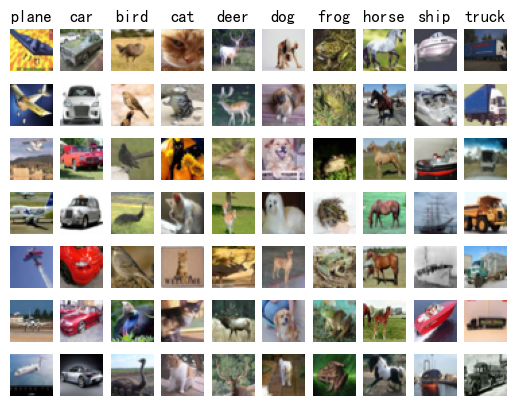

In [5]:
from configs import cifar10_classes, num_classes

samples_per_class = 7

for y, cls in enumerate(cifar10_classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## 2. 模型训练

本实验中我尝试了多种模型，包括 LeNet、AlexNet、VGGNet、ResNet 这几种经典的卷积神经网络模型，并比较了相似架构下拥有不同参数网络的性能，观察了引入批量正则化与否对网络性能的影响。

### 2.1 LeNet

首先使用比较简单的 LeNet 模型。

In [6]:
from lenet_utils import LeNet

model = LeNet()
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True)

查看网络结构。

In [7]:
summary(model.to(device='cuda'), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


训练模型，记录训练过程的损失以及训练和验证过程的准确率，保留最优模型。

In [8]:
from train import train
from configs import generate_save_dir

best_model, train_loss_history, train_acc_history, val_acc_history = train(
    model, criterion, optimizer, lr_scheduler, loader_train, loader_val,
    epochs=10, save_dir=generate_save_dir('lenet5.pth', False)
)

 |##################################################| 100.0% Iter 350, loss = 1.3475
Epoch 1 / 10	train_acc = 0.3183, val_acc = 0.4470
 |##################################################| 100.0% Iter 350, loss = 1.4634
Epoch 2 / 10	train_acc = 0.4768, val_acc = 0.5320
 |##################################################| 100.0% Iter 350, loss = 1.3734
Epoch 3 / 10	train_acc = 0.5319, val_acc = 0.5570
 |##################################################| 100.0% Iter 350, loss = 1.2367
Epoch 4 / 10	train_acc = 0.5710, val_acc = 0.6050
 |##################################################| 100.0% Iter 350, loss = 1.0244
Epoch 5 / 10	train_acc = 0.5932, val_acc = 0.5960
 |##################################################| 100.0% Iter 350, loss = 1.1256
Epoch 6 / 10	train_acc = 0.6136, val_acc = 0.5860
 |##################################################| 100.0% Iter 350, loss = 0.9621
Epoch 00007: reducing learning rate of group 0 to 1.0000e-03.
Epoch 7 / 10	train_acc = 0.6266, val_acc = 

绘制训练过程中 loss 和 acc 的变化曲线。

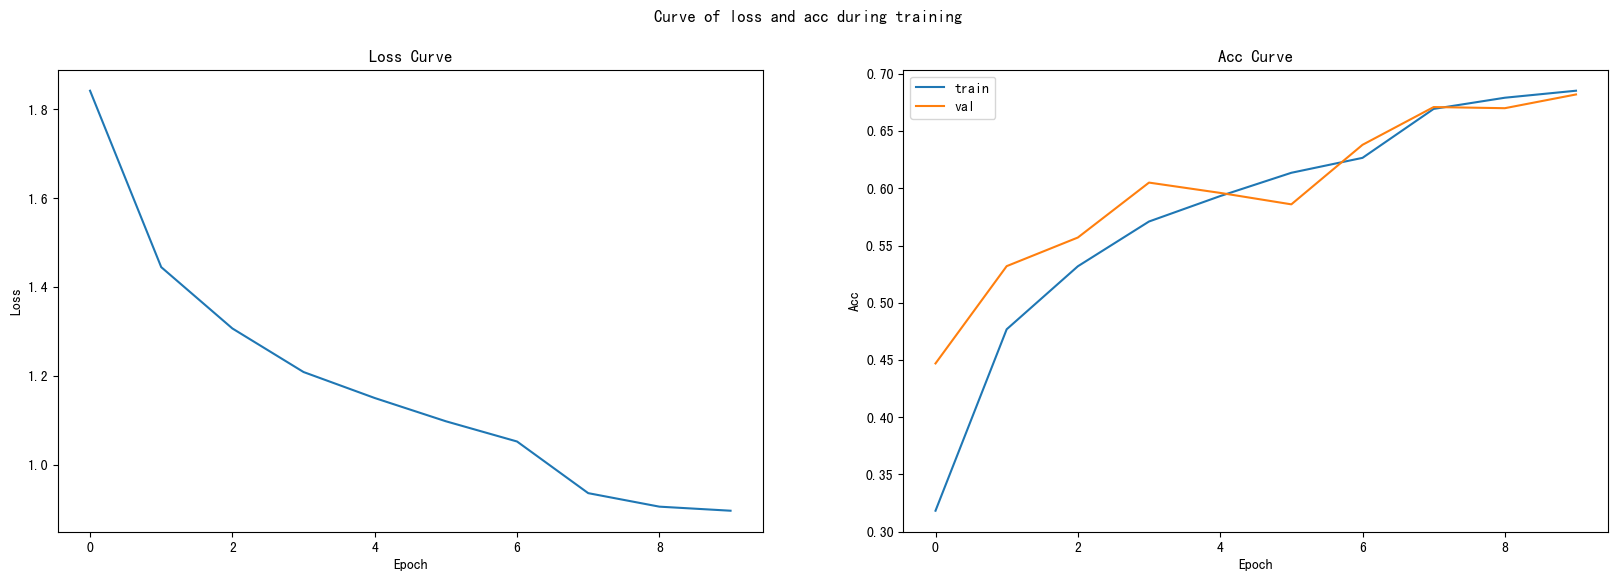

In [9]:
x_points = np.array(range(len(train_loss_history)), dtype=int)
plt.figure(figsize=(20, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(x_points, train_loss_history, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')

# Acc plot
plt.subplot(1, 2, 2)
plt.plot(x_points, train_acc_history, '-', label='train')
plt.plot(x_points, val_acc_history, '-', label='val')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Acc Curve')
plt.legend()

plt.suptitle('Curve of loss and acc during training')
plt.show()

检验模型效果。

In [10]:
from train import check_accuracy

_ = check_accuracy(best_model, loader_test)

Checking accuracy on test set
Got 6514 / 10000 correct (65.14)
Class	Accuracy
----------------
plane 	 |  68.0
car   	 |  76.6
bird  	 |  54.6
cat   	 |  47.7
deer  	 |  58.6
dog   	 |  49.5
frog  	 |  76.1
horse 	 |  70.1
ship  	 |  79.0
truck 	 |  71.2


LeNet 模型比较简单，训练速度较快，参数较少，但对较复杂的图片准确度不高。

### 2.2 AlexNet

使用稍微复杂一点的 AlexNet 模型。

In [11]:
from alexnet_utils import AlexNet

model = AlexNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True)

查看网络结构。

In [12]:
summary(model.to(device='cuda'), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,792
              ReLU-2           [-1, 64, 16, 16]               0
         MaxPool2d-3             [-1, 64, 8, 8]               0
            Conv2d-4            [-1, 192, 8, 8]         110,784
              ReLU-5            [-1, 192, 8, 8]               0
         MaxPool2d-6            [-1, 192, 4, 4]               0
            Conv2d-7            [-1, 384, 4, 4]         663,936
              ReLU-8            [-1, 384, 4, 4]               0
            Conv2d-9            [-1, 256, 4, 4]         884,992
             ReLU-10            [-1, 256, 4, 4]               0
           Conv2d-11            [-1, 256, 4, 4]         590,080
             ReLU-12            [-1, 256, 4, 4]               0
        MaxPool2d-13            [-1, 256, 2, 2]               0
          Dropout-14                 [-

训练模型，记录训练过程的损失以及训练和验证过程的准确率，保留最优模型。

In [13]:
best_model, train_loss_history, train_acc_history, val_acc_history = train(
    model, criterion, optimizer, lr_scheduler, loader_train, loader_val,
    epochs=10, save_dir=generate_save_dir('alexnet.pth', False)
)

 |##################################################| 100.0% Iter 350, loss = 1.5791
Epoch 1 / 10	train_acc = 0.2999, val_acc = 0.4870
 |##################################################| 100.0% Iter 350, loss = 1.3361
Epoch 2 / 10	train_acc = 0.5042, val_acc = 0.5850
 |##################################################| 100.0% Iter 350, loss = 1.1706
Epoch 3 / 10	train_acc = 0.5843, val_acc = 0.6320
 |##################################################| 100.0% Iter 350, loss = 1.0483
Epoch 4 / 10	train_acc = 0.6368, val_acc = 0.6750
 |##################################################| 100.0% Iter 350, loss = 0.9161
Epoch 5 / 10	train_acc = 0.6715, val_acc = 0.6920
 |##################################################| 100.0% Iter 350, loss = 0.8833
Epoch 6 / 10	train_acc = 0.7011, val_acc = 0.7060
 |##################################################| 100.0% Iter 350, loss = 0.6670
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7 / 10	train_acc = 0.7190, val_acc = 

绘制训练过程中 loss 和 acc 的变化曲线。

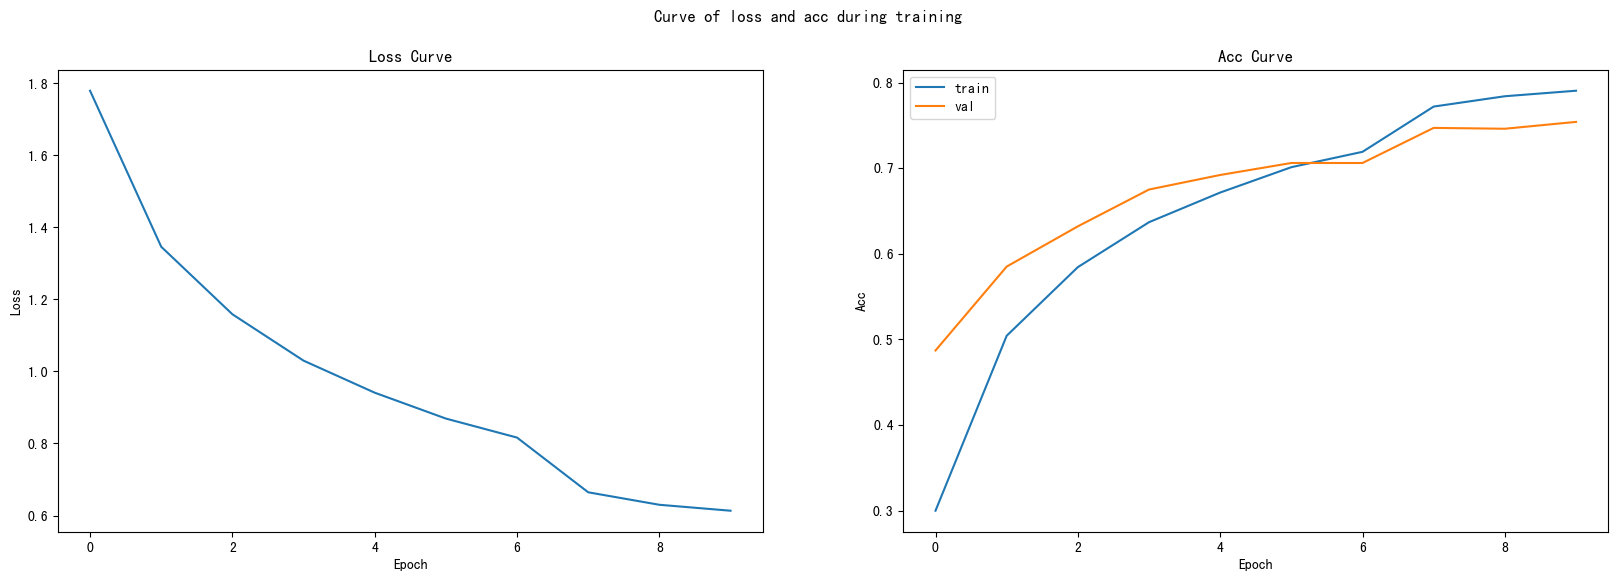

In [14]:
x_points = np.array(range(len(train_loss_history)), dtype=int)
plt.figure(figsize=(20, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(x_points, train_loss_history, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')

# Acc plot
plt.subplot(1, 2, 2)
plt.plot(x_points, train_acc_history, '-', label='train')
plt.plot(x_points, val_acc_history, '-', label='val')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Acc Curve')
plt.legend()

plt.suptitle('Curve of loss and acc during training')
plt.show()

检验模型效果。

In [15]:
_ = check_accuracy(best_model, loader_test)

Checking accuracy on test set
Got 7356 / 10000 correct (73.56)
Class	Accuracy
----------------
plane 	 |  78.5
car   	 |  83.4
bird  	 |  62.2
cat   	 |  55.1
deer  	 |  67.1
dog   	 |  59.4
frog  	 |  83.1
horse 	 |  78.7
ship  	 |  84.3
truck 	 |  83.8


可以看出，AlexNet 的准确率相比 LeNet 有了一定的提升，但仍然不算太高。

### 2.3 简易 ResNet

手动搭建一个简易的 ResNet。

In [16]:
from demo_utils import ResNet9

model = ResNet9()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True)
# lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=10, steps_per_epoch=len(loader_train))

查看网络结构。

In [17]:
summary(model.to(device='cuda'), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

训练模型，记录训练过程的损失以及训练和验证过程的准确率，保留最优模型。

In [18]:
best_model, train_loss_history, train_acc_history, val_acc_history = train(
    model, criterion, optimizer, lr_scheduler, loader_train, loader_val,
    epochs=20, save_dir=generate_save_dir('demo.pth', False)
)

 |##################################################| 100.0% Iter 350, loss = 1.2513
Epoch 1 / 20	train_acc = 0.5456, val_acc = 0.7040
 |##################################################| 100.0% Iter 350, loss = 0.7642
Epoch 2 / 20	train_acc = 0.7363, val_acc = 0.6760
 |##################################################| 100.0% Iter 350, loss = 0.4955
Epoch 3 / 20	train_acc = 0.7978, val_acc = 0.7880
 |##################################################| 100.0% Iter 350, loss = 0.3541
Epoch 4 / 20	train_acc = 0.8242, val_acc = 0.7890
 |##################################################| 100.0% Iter 350, loss = 0.4730
Epoch 5 / 20	train_acc = 0.8494, val_acc = 0.7870
 |##################################################| 100.0% Iter 350, loss = 0.3231
Epoch 6 / 20	train_acc = 0.8689, val_acc = 0.8430
 |##################################################| 100.0% Iter 350, loss = 0.3611
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7 / 20	train_acc = 0.8794, val_acc = 

绘制训练过程中 loss 和 acc 的变化曲线。

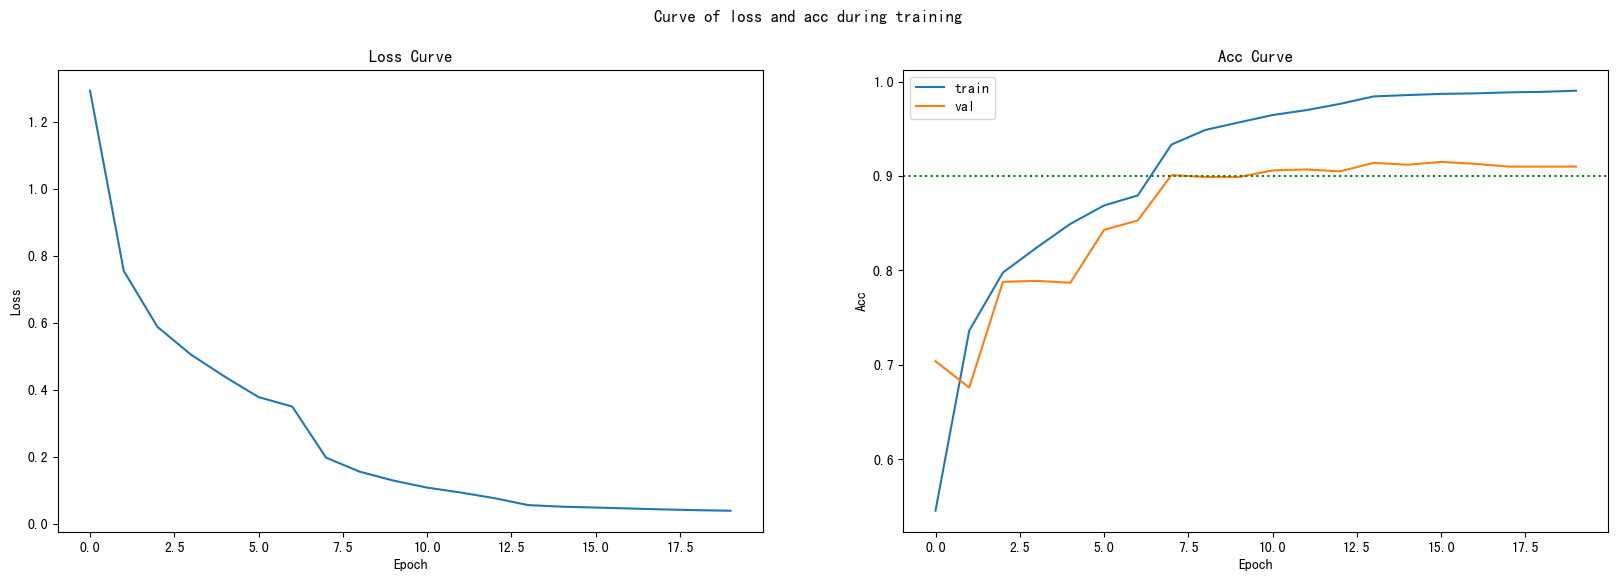

In [19]:
x_points = np.array(range(len(train_loss_history)), dtype=int)
plt.figure(figsize=(20, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(x_points, train_loss_history, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')

# Acc plot
plt.subplot(1, 2, 2)
plt.plot(x_points, train_acc_history, '-', label='train')
plt.plot(x_points, val_acc_history, '-', label='val')
plt.axhline(y=0.9, ls=':', c='green')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Acc Curve')
plt.legend()

plt.suptitle('Curve of loss and acc during training')
plt.show()

检验模型效果。

In [20]:
_ = check_accuracy(best_model, loader_test)

Checking accuracy on test set
Got 9164 / 10000 correct (91.64)
Class	Accuracy
----------------
plane 	 |  94.0
car   	 |  96.3
bird  	 |  88.5
cat   	 |  83.8
deer  	 |  92.3
dog   	 |  86.3
frog  	 |  93.6
horse 	 |  92.3
ship  	 |  95.0
truck 	 |  94.3


### 2.4 VGGNet

对 VGGNet 的输入和输出进行修改，使之能够用于 CIFAR-10 数据集。

In [21]:
from vgg_utils import *

model = vgg19_bn(pretrained=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True)

查看网络结构。

In [22]:
summary(model.to(device='cuda'), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

训练模型，记录训练过程的损失以及训练和验证过程的准确率，保留最优模型。

In [23]:
best_model, train_loss_history, train_acc_history, val_acc_history = train(
    model, criterion, optimizer, lr_scheduler, loader_train, loader_val,
    epochs=20, save_dir=generate_save_dir('vggnet.pth', False)
)

 |##################################################| 100.0% Iter 350, loss = 0.8504
Epoch 1 / 20	train_acc = 0.6498, val_acc = 0.6990
 |##################################################| 100.0% Iter 350, loss = 0.8009
Epoch 2 / 20	train_acc = 0.7946, val_acc = 0.8070
 |##################################################| 100.0% Iter 350, loss = 0.4162
Epoch 3 / 20	train_acc = 0.8312, val_acc = 0.8180
 |##################################################| 100.0% Iter 350, loss = 0.5273
Epoch 4 / 20	train_acc = 0.8481, val_acc = 0.8250
 |##################################################| 100.0% Iter 350, loss = 0.4734
Epoch 5 / 20	train_acc = 0.8660, val_acc = 0.8180
 |##################################################| 100.0% Iter 350, loss = 0.2581
Epoch 6 / 20	train_acc = 0.8797, val_acc = 0.8520
 |##################################################| 100.0% Iter 350, loss = 0.4565
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7 / 20	train_acc = 0.8886, val_acc = 

绘制训练过程中 loss 和 acc 的变化曲线。

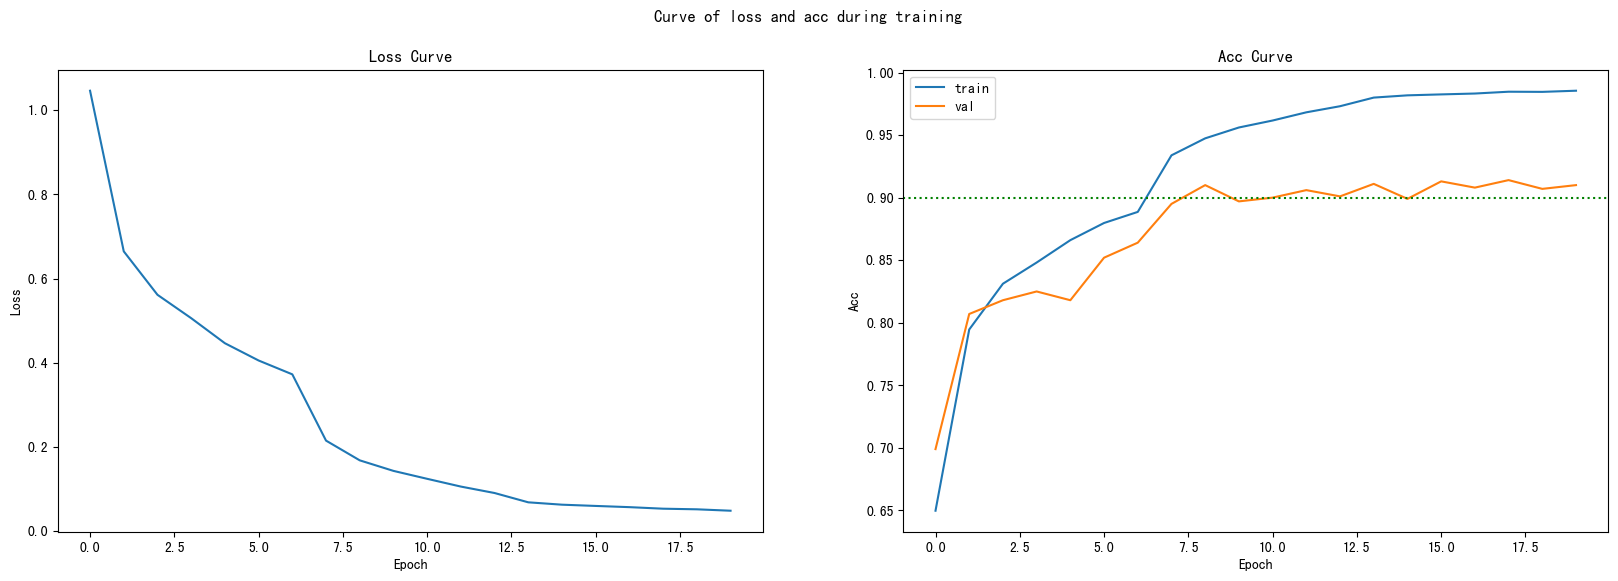

In [24]:
x_points = np.array(range(len(train_loss_history)), dtype=int)
plt.figure(figsize=(20, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(x_points, train_loss_history, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')

# Acc plot
plt.subplot(1, 2, 2)
plt.plot(x_points, train_acc_history, '-', label='train')
plt.plot(x_points, val_acc_history, '-', label='val')
plt.axhline(y=0.9, ls=':', c='green')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Acc Curve')
plt.legend()

plt.suptitle('Curve of loss and acc during training')
plt.show()

上述模型是采用预训练得到的，下面将其与未进行预训练的模型进行对比。

In [25]:
model_nopre = vgg19_bn()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_nopre.parameters(), lr=1e-3, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True)

查看网络结构。

In [26]:
summary(model_nopre.to(device='cuda'), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

训练模型，记录训练过程的损失以及训练和验证过程的准确率，保留最优模型。

In [27]:
best_model_nopre, train_loss_history_nopre, train_acc_history_nopre, val_acc_history_nopre = train(
    model_nopre, criterion, optimizer, lr_scheduler, loader_train, loader_val,
    epochs=20
)

 |##################################################| 100.0% Iter 350, loss = 1.7038
Epoch 1 / 20	train_acc = 0.2289, val_acc = 0.3220
 |##################################################| 100.0% Iter 350, loss = 1.4084
Epoch 2 / 20	train_acc = 0.3822, val_acc = 0.4250
 |##################################################| 100.0% Iter 350, loss = 1.3119
Epoch 3 / 20	train_acc = 0.5099, val_acc = 0.5260
 |##################################################| 100.0% Iter 350, loss = 1.2144
Epoch 4 / 20	train_acc = 0.5905, val_acc = 0.5310
 |##################################################| 100.0% Iter 350, loss = 0.9547
Epoch 5 / 20	train_acc = 0.6307, val_acc = 0.6310
 |##################################################| 100.0% Iter 350, loss = 0.8791
Epoch 6 / 20	train_acc = 0.6576, val_acc = 0.6230
 |##################################################| 100.0% Iter 350, loss = 0.7214
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7 / 20	train_acc = 0.6918, val_acc = 

绘制训练过程中 loss 和 acc 的变化曲线。

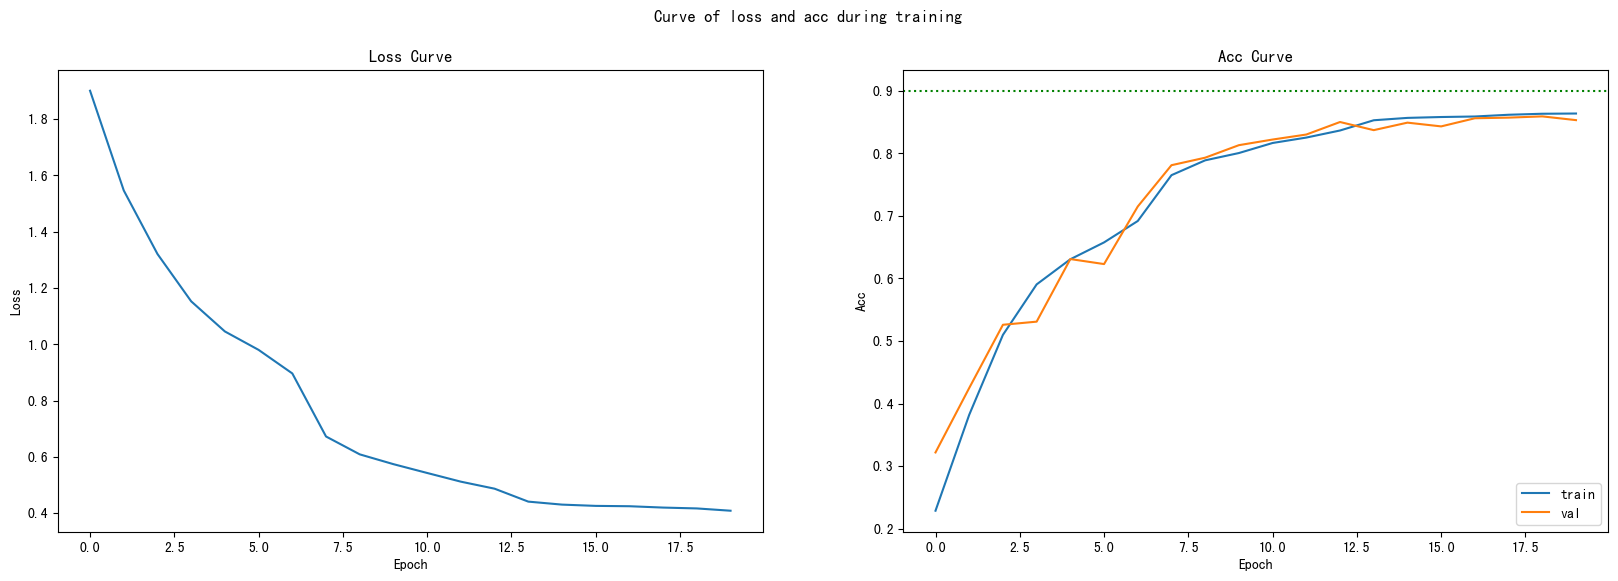

In [28]:
x_points = np.array(range(len(train_loss_history)), dtype=int)
plt.figure(figsize=(20, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(x_points, train_loss_history_nopre, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')

# Acc plot
plt.subplot(1, 2, 2)
plt.plot(x_points, train_acc_history_nopre, '-', label='train')
plt.plot(x_points, val_acc_history_nopre, '-', label='val')
plt.axhline(y=0.9, ls=':', c='green')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Acc Curve')
plt.legend()

plt.suptitle('Curve of loss and acc during training')
plt.show()

比较一下使用预训练前后的模型性能，绘制准确率曲线。

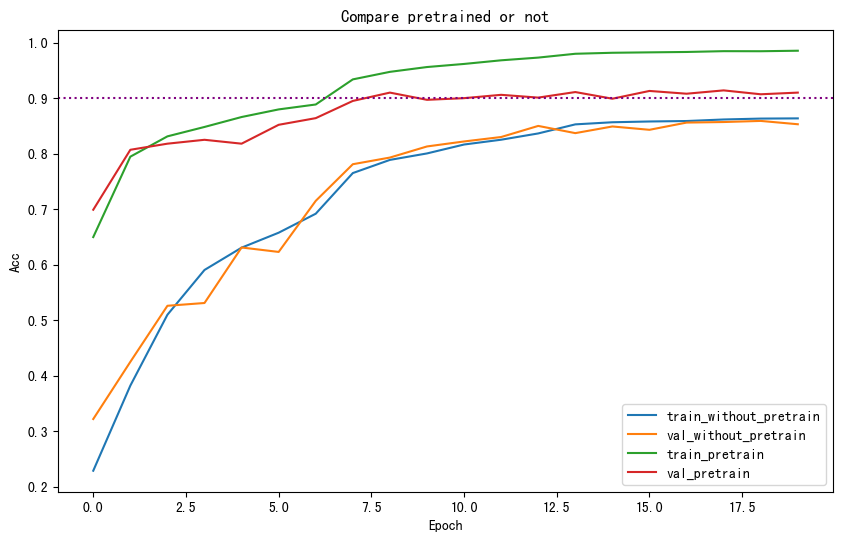

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(train_acc_history_nopre, '-', label='train_without_pretrain')
plt.plot(val_acc_history_nopre, '-', label='val_without_pretrain')
plt.plot(train_acc_history, '-', label='train_pretrain')
plt.plot(val_acc_history, '-', label='val_pretrain')
plt.axhline(y=0.9, ls=':', c='purple')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Compare pretrained or not')
plt.legend()
plt.show()

可以看出，使用预训练后模型收敛速度更快。

In [30]:
_ = check_accuracy(best_model, loader_test)
_ = check_accuracy(best_model_nopre, loader_test)

Checking accuracy on test set
Got 9015 / 10000 correct (90.15)
Class	Accuracy
----------------
plane 	 |  91.8
car   	 |  96.0
bird  	 |  87.2
cat   	 |  79.2
deer  	 |  89.9
dog   	 |  85.4
frog  	 |  93.2
horse 	 |  92.5
ship  	 |  93.0
truck 	 |  93.3
Checking accuracy on test set
Got 8342 / 10000 correct (83.42)
Class	Accuracy
----------------
plane 	 |  87.2
car   	 |  93.6
bird  	 |  76.4
cat   	 |  69.7
deer  	 |  83.0
dog   	 |  66.1
frog  	 |  88.1
horse 	 |  88.7
ship  	 |  90.4
truck 	 |  91.0


从效果上看，……

### 2.4 ResNet

对 ResNet 的输入和输出进行修改，使之能够用于 CIFAR-10 数据集。

In [31]:
from resnet_utils import *

model = resnet50(pretrained=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True)

查看网络结构。

In [32]:
summary(model.to(device='cuda'), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

训练模型，记录训练过程的损失以及训练和验证过程的准确率，保留最优模型。

In [33]:
best_model, train_loss_history, train_acc_history, val_acc_history = train(
    model, criterion, optimizer, lr_scheduler, loader_train, loader_val,
    epochs=20, save_dir=generate_save_dir('resnet50.pth', False)
)

 |##################################################| 100.0% Iter 350, loss = 0.7905
Epoch 1 / 20	train_acc = 0.6331, val_acc = 0.7260
 |##################################################| 100.0% Iter 350, loss = 0.6385
Epoch 2 / 20	train_acc = 0.7803, val_acc = 0.8000
 |##################################################| 100.0% Iter 350, loss = 0.4619
Epoch 3 / 20	train_acc = 0.8267, val_acc = 0.8250
 |##################################################| 100.0% Iter 350, loss = 0.4279
Epoch 4 / 20	train_acc = 0.8520, val_acc = 0.8070
 |##################################################| 100.0% Iter 350, loss = 0.4716
Epoch 5 / 20	train_acc = 0.8668, val_acc = 0.8280
 |##################################################| 100.0% Iter 350, loss = 0.3878
Epoch 6 / 20	train_acc = 0.8819, val_acc = 0.8330
 |##################################################| 100.0% Iter 350, loss = 0.3198
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7 / 20	train_acc = 0.8921, val_acc = 

绘制训练过程中 loss 和 acc 的变化曲线。

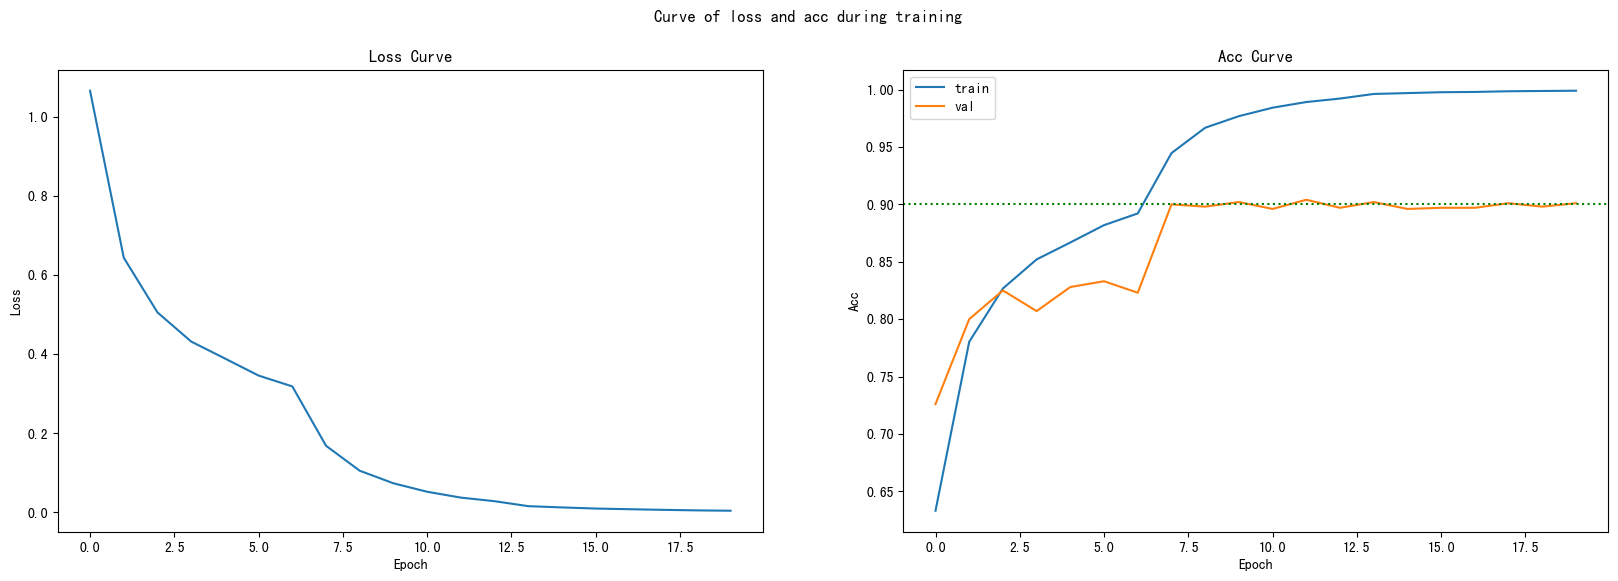

In [34]:
x_points = np.array(range(len(train_loss_history)), dtype=int)
plt.figure(figsize=(20, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(x_points, train_loss_history, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')

# Acc plot
plt.subplot(1, 2, 2)
plt.plot(x_points, train_acc_history, '-', label='train')
plt.plot(x_points, val_acc_history, '-', label='val')
plt.axhline(y=0.9, ls=':', c='green')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Acc Curve')
plt.legend()

plt.suptitle('Curve of loss and acc during training')
plt.show()

比较拥有不同参数的 ResNet 网络的性能。

In [35]:
model2 = resnet18(pretrained=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=1e-3, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True)

In [36]:
summary(model2.to(device='cuda'), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [37]:
best_model2, train_loss_history2, train_acc_history2, val_acc_history2 = train(
    model2, criterion, optimizer, lr_scheduler, loader_train, loader_val,
    epochs=20
)

 |##################################################| 100.0% Iter 350, loss = 0.6555
Epoch 1 / 20	train_acc = 0.6439, val_acc = 0.7030
 |##################################################| 100.0% Iter 350, loss = 0.6968
Epoch 2 / 20	train_acc = 0.7853, val_acc = 0.7840
 |##################################################| 100.0% Iter 350, loss = 0.5034
Epoch 3 / 20	train_acc = 0.8280, val_acc = 0.8010
 |##################################################| 100.0% Iter 350, loss = 0.4219
Epoch 4 / 20	train_acc = 0.8558, val_acc = 0.8100
 |##################################################| 100.0% Iter 350, loss = 0.3390
Epoch 5 / 20	train_acc = 0.8737, val_acc = 0.8290
 |##################################################| 100.0% Iter 350, loss = 0.3612
Epoch 6 / 20	train_acc = 0.8897, val_acc = 0.8390
 |##################################################| 100.0% Iter 350, loss = 0.2429
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7 / 20	train_acc = 0.9002, val_acc = 

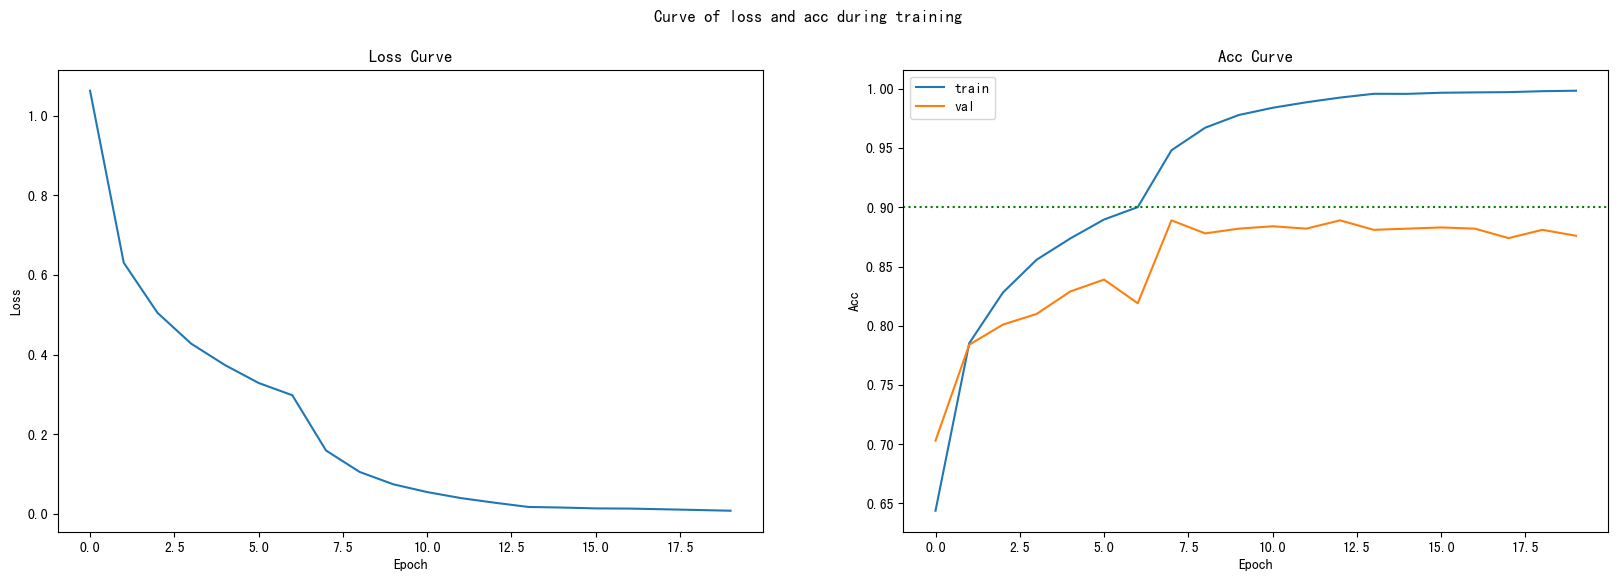

In [38]:
x_points = np.array(range(len(train_loss_history2)), dtype=int)
plt.figure(figsize=(20, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(x_points, train_loss_history2, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')

# Acc plot
plt.subplot(1, 2, 2)
plt.plot(x_points, train_acc_history2, '-', label='train')
plt.plot(x_points, val_acc_history2, '-', label='val')
plt.axhline(y=0.9, ls=':', c='green')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Acc Curve')
plt.legend()

plt.suptitle('Curve of loss and acc during training')
plt.show()

比较一下两种网络的性能，绘制准确率曲线。

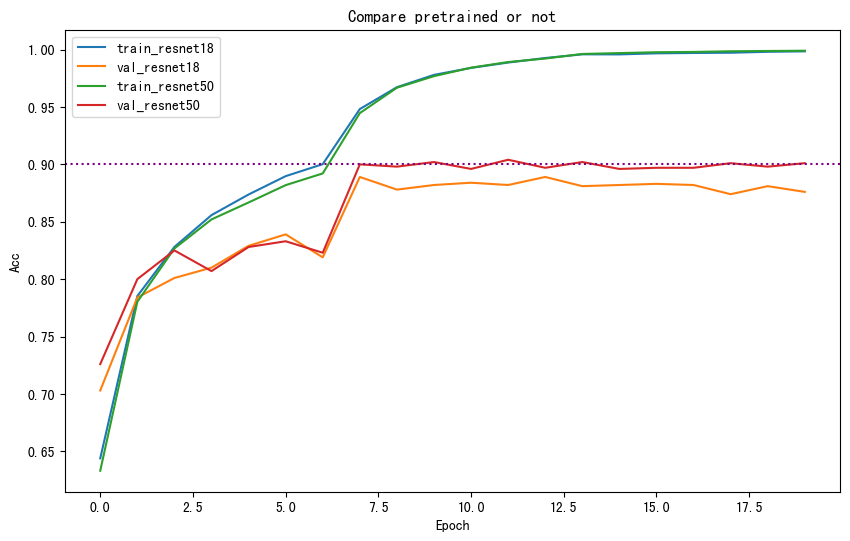

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(train_acc_history2, '-', label='train_resnet18')
plt.plot(val_acc_history2, '-', label='val_resnet18')
plt.plot(train_acc_history, '-', label='train_resnet50')
plt.plot(val_acc_history, '-', label='val_resnet50')
plt.axhline(y=0.9, ls=':', c='purple')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Compare pretrained or not')
plt.legend()
plt.show()

可以看出，……

In [40]:
_ = check_accuracy(best_model, loader_test)
_ = check_accuracy(best_model_nopre, loader_test)

Checking accuracy on test set
Got 8959 / 10000 correct (89.59)
Class	Accuracy
----------------
plane 	 |  92.0
car   	 |  95.7
bird  	 |  86.5
cat   	 |  77.0
deer  	 |  88.6
dog   	 |  84.3
frog  	 |  93.3
horse 	 |  91.8
ship  	 |  93.3
truck 	 |  93.4
Checking accuracy on test set
Got 8342 / 10000 correct (83.42)
Class	Accuracy
----------------
plane 	 |  87.2
car   	 |  93.6
bird  	 |  76.4
cat   	 |  69.7
deer  	 |  83.0
dog   	 |  66.1
frog  	 |  88.1
horse 	 |  88.7
ship  	 |  90.4
truck 	 |  91.0


从效果上看，……

## 3. 可视化特征图

以 ResNet50 为例。首先定义相关的函数。

In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import torchvision.utils as vutil
# from configs import IMAGE_DIR

IMAGE_DIR = os.path.join(os.path.dirname(DATA_DIR), 'images')

DEMO_DIR = None


def hook_func(module, input, output):
    """
    Hook function of register_forward_hook

    Parameters:
    -----------
    module: module of neural network
    input: input of module
    output: output of module
    """
    image_name = get_image_name_for_hook(module)
    data = output.clone().detach()
    data = data.permute(1, 0, 2, 3)
    vutil.save_image(data, image_name, pad_value=0.5)


def get_image_name_for_hook(module):
    """
    Generate image filename for hook function

    Parameters:
    -----------
    module: module of neural network
    """
    os.makedirs(DEMO_DIR, exist_ok=True)
    base_name = str(module).split('(')[0]
    index = 0
    image_name = '.'  # '.' is surely exist, to make first loop condition True
    while os.path.exists(image_name):
        index += 1
        image_name = os.path.join(
            DEMO_DIR, '%s_%d.png' % (base_name, index))
    return image_name

然后保存特征图到指定目录。

In [48]:
model = model.to(device='cuda' if torch.cuda.is_available() else 'cpu')
modules_for_plot = (torch.nn.ReLU, torch.nn.Conv2d,
                    torch.nn.MaxPool2d, torch.nn.AdaptiveAvgPool2d)
for name, module in model.named_modules():
    if isinstance(module, modules_for_plot):
        module.register_forward_hook(hook_func)

index = 1
loader = DataLoader(dataset=cifar10_test, batch_size=1, shuffle=False)
for data, classes in loader:
    DEMO_DIR = os.path.join(
        IMAGE_DIR, '%d-%d' % (index, classes.item())
    )
    data, classes = data.cuda(), classes.cuda()
    outputs = model(data)
    index += 1
    if index > 20:
        break

显示一张特征图。

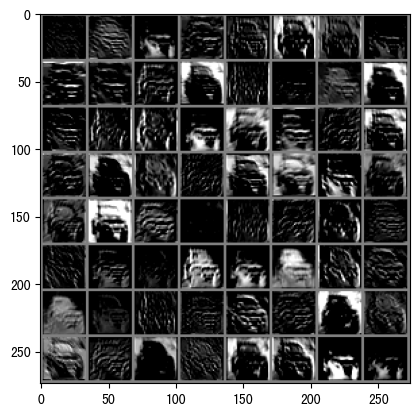

In [49]:
from PIL import Image

im = Image.open(IMAGE_DIR + '/10-1/Conv2d_1.png', 'r')
plt.imshow(im)